librerias

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

funciones

In [43]:
def seconds_to_hms(seconds):
    """Convierte segundos flotantes a formato Hh Mm Ss."""
    if pd.isna(seconds):
        return "N/A"
    seconds = round(seconds)
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return f"{int(h)}h {int(m)}m {int(s)}s"

In [44]:
def format_mmss(x, pos):
    """Formatea el tiempo en MM:ss o H:MM:ss si es muy largo"""
    if x < 60:
        return f"00:{int(x):02d}"  # Ej: 00:45
    elif x < 3600:
        m = int(x // 60)
        s = int(x % 60)
        return f"{m:02d}:{s:02d}"  # Ej: 05:30
    else:
        h = int(x // 3600)
        m = int((x % 3600) // 60)
        return f"{h}h {m:02d}m"

In [45]:
def obtener_top_n_transiciones(row, n=4):
    """Extrae las N transiciones con mayor probabilidad para una fila (página)."""
    top_n = row.nlargest(n)
    
    resultado = {}
    for i in range(n):
        if i < len(top_n):
            probabilidad_porcentual = top_n.iloc[i] * 100
            destino = top_n.index[i]
        else:
            probabilidad_porcentual = 0.0
            destino = "N/A"
            
        resultado[f'Prob_{i+1} (%)'] = probabilidad_porcentual
        resultado[f'Destino_{i+1}'] = destino
            
    return pd.Series(resultado)

In [46]:
def format_destino(destino):
    """Añade marcadores visuales a los destinos de riesgo (FIN_TEST, ABANDONO_LARGO)."""
    if destino == 'FIN_TEST':
        return '★ FIN_TEST'
    elif destino == 'ABANDONO_LARGO':
        return '🔴 ABANDONO_LARGO'
    return destino

carga de datos

### --- 1. Carga, Preprocesamiento y Cálculo de Latencia ---


In [47]:
FILE_NAME = "Datos alumnos/Originales/Datos UX/page_views_2.csv"

In [48]:
print(f"Cargando el archivo: {FILE_NAME}...")
df = pd.read_csv(FILE_NAME, sep=";")
display(df.head(3))
df.rename(columns={'event_date_': 'event_date', 
                   'event_timestamp_': 'event_timestamp'}, 
          inplace=True)

df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], errors='coerce') 
df = df.sort_values(by=['user_id', 'event_timestamp']).reset_index(drop=True)

Cargando el archivo: Datos alumnos/Originales/Datos UX/page_views_2.csv...


,event_name,section,user_id,event_date_,event_timestamp_
0,page_view,quiz_work,040e1e30c9ed4248bc9799a707e36d60,2025-01-01,2025-01-01 16:57:15.062114990
1,page_view,quiz_fit,040e1e30c9ed4248bc9799a707e36d60,2025-01-01,2025-01-01 16:57:24.243407959
2,page_view,quiz_highlight,040e1e30c9ed4248bc9799a707e36d60,2025-01-01,2025-01-01 16:57:37.877279053


In [49]:
# Cálculo de Latencia y Siguiente Sección
df['next_timestamp'] = df.groupby('user_id')['event_timestamp'].shift(-1)
df['latency_seconds'] = (df['next_timestamp'] - df['event_timestamp']).dt.total_seconds()
df['next_section'] = df.groupby('user_id')['section'].shift(-1)

### --- 2. CÁLCULO DE SECUENCIAS Y CONTEO ---

In [50]:
# Calcular la secuencia de páginas (path_sequence) por usuario
serie_secuencias = df.groupby('user_id')['section'].apply(lambda x: ' -> '.join(x))

# Contar las ocurrencias de cada secuencia y obtener el Top 28
rutas_contadas = serie_secuencias.value_counts().head(28)

# Convertir las rutas contadas a una lista de tuplas (secuencia_string, conteo)
rutas_crudo = list(rutas_contadas.items())
total_rutas = rutas_contadas.sum()

In [51]:
# --- DEFINICIÓN AUTOMÁTICA DEL FLUJO IDEAL ---

# Obtener la cadena de texto del camino más frecuente (el índice [0] de la Serie)
camino_mas_frecuente_str = rutas_contadas.index[0]

# Definir el Flujo Ideal (lista de páginas secuenciales)
flujo_ideal_lista = [s.strip() for s in camino_mas_frecuente_str.split('->')]

In [52]:
# Variable para el bucle: crear un diccionario de mapeo (Origen -> Destino)
# Esto será el Flujo Secuencial, incluyendo el paso final (FIN_TEST)
flujo_secuencial_mapa = {
    flujo_ideal_lista[i]: flujo_ideal_lista[i+1]
    for i in range(len(flujo_ideal_lista) - 1)
}

# Añadir el paso final (la última página -> FIN_TEST)
flujo_secuencial_mapa[flujo_ideal_lista[-1]] = 'FIN_TEST'

In [53]:
# --- ANÁLISIS DE CONTEXTO ---

# Mostrar el contexto de las rutas contadas (simplificación de display(caminos_seguidos))
print("### Rutas de Usuario Más Frecuentes (Top 28)")
display(rutas_contadas)

print("\n### Flujo Ideal (Secuencia Más Frecuente)")
print(f"Flujo: {' -> '.join(flujo_ideal_lista)}")
print(f"Frecuencia: {rutas_contadas.iloc[0]} rutas.")

### Rutas de Usuario Más Frecuentes (Top 28)


section
quiz_work -> quiz_fit -> quiz_highlight -> quiz_bodyShape -> quiz_eyes -> quiz_hair -> quiz_sizes -> quiz_measurements -> quiz_focus -> quiz_adventurous -> quiz_styles -> quiz_prices -> quiz_avoid -> quiz_footwear -> quiz_you -> quiz_photos -> quiz_social -> quiz_signUp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      11
quiz_work -> quiz_fit -> quiz_highlight -> quiz_bodyShape -> quiz_eyes -> quiz_hair -> quiz_sizes -> quiz_measurements ->


### Flujo Ideal (Secuencia Más Frecuente)
Flujo: quiz_work -> quiz_fit -> quiz_highlight -> quiz_bodyShape -> quiz_eyes -> quiz_hair -> quiz_sizes -> quiz_measurements -> quiz_focus -> quiz_adventurous -> quiz_styles -> quiz_prices -> quiz_avoid -> quiz_footwear -> quiz_you -> quiz_photos -> quiz_social -> quiz_signUp
Frecuencia: 11 rutas.


In [54]:
# Mostrar contexto de las transiciones (simplificación del display(df.head(10)))
df['seccion_anterior'] = df.groupby('user_id')['section'].shift(1)
print("\n### Ejemplo de Estructura de Transición")
display(df[['user_id', 'event_timestamp', 'seccion_anterior', 'section', 'next_section']].head(3))

# Definición de variables globales para la siguiente celda:
# - rutas_crudo (lista de tuplas): Paths y sus conteos
# - total_rutas (int): Suma total de rutas analizadas
# - flujo_ideal_lista (list): Secuencia lineal de páginas del camino más común
# - flujo_secuencial_mapa (dict): Mapeo {Origen: Destino} para el bucle de la matriz de Markov.


### Ejemplo de Estructura de Transición


,user_id,event_timestamp,seccion_anterior,section,next_section
0,040e1e30c9ed4248bc9799a707e36d60,2025-01-01 16:57:15.062114990,NaN,quiz_work,quiz_fit
1,040e1e30c9ed4248bc9799a707e36d60,2025-01-01 16:57:24.243407959,quiz_work,quiz_fit,quiz_highlight
2,040e1e30c9ed4248bc9799a707e36d60,2025-01-01 16:57:37.877279053,quiz_fit,quiz_highlight,quiz_bodyShape


#### Analizar latencias temporales, para detectar abandonos a la hora de completar el cuestionario

In [55]:
# Eliminar filas donde no hay latencia (último evento de cada usuario) para el análisis de distribución
df_continuacion = df.dropna(subset=['latency_seconds']).copy()
latencias = df_continuacion['latency_seconds'].sort_values().reset_index(drop=True)

In [56]:
# Definir la lista de percentiles para el gráfico (mayor densidad en la cola)
percentiles_list = np.linspace(0.75, 0.999, 200) # Generación simplificada
percentiles_list = percentiles_list[percentiles_list < 1.0] 
valores_latencia = latencias.quantile(percentiles_list)

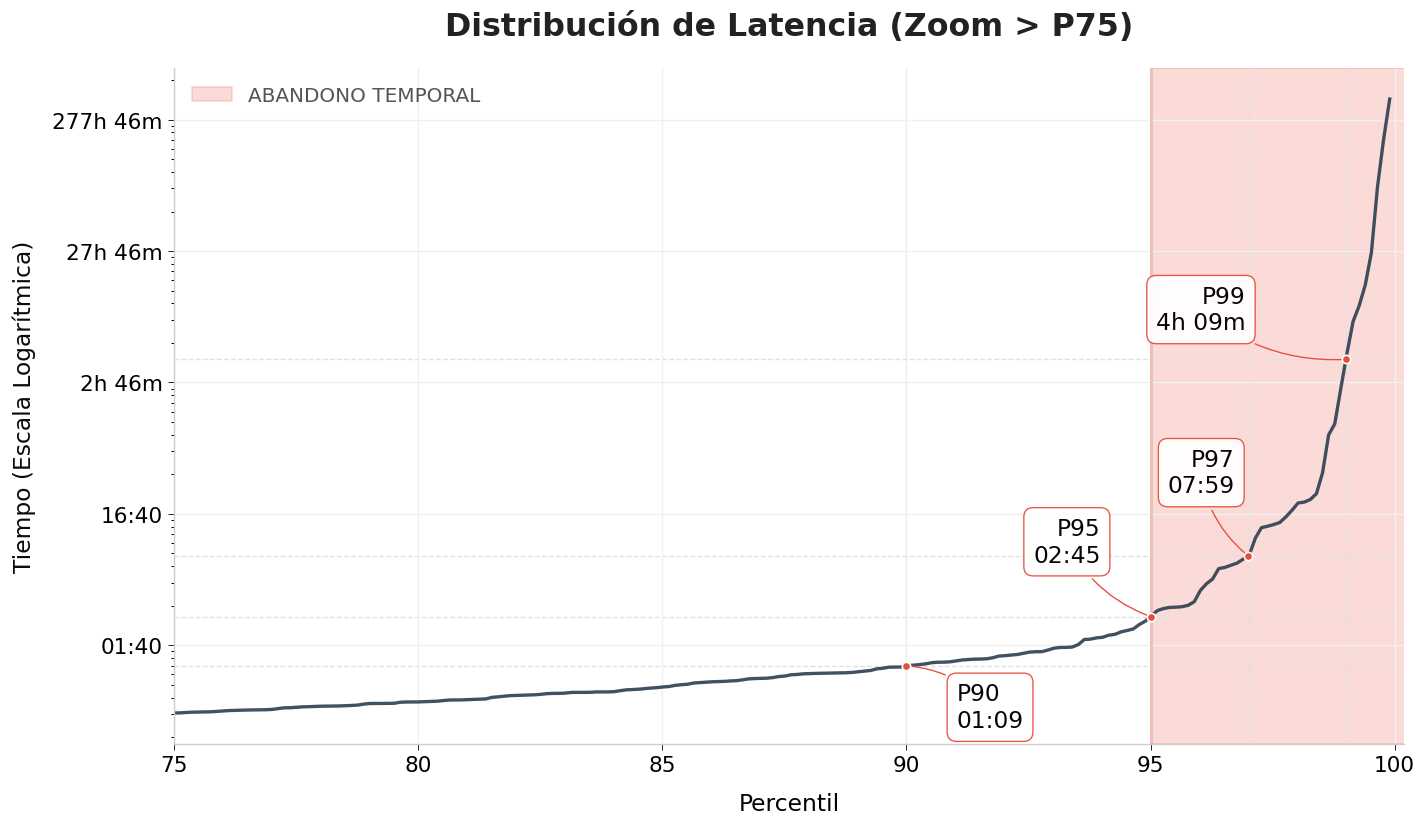

In [57]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=120)
ax.set_facecolor('white')

ax.axvspan(95, 100.5, color='#e74c3c', alpha=0.2, label='ABANDONO TEMPORAL')

ax.plot(percentiles_list * 100, valores_latencia, color='#2c3e50', linewidth=2, alpha=0.9)

ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_mmss))

key_quantiles = [0.90, 0.95, 0.97, 0.99]
key_values = latencias.quantile(key_quantiles)

offsets = {
    0.90: (30, -10),
    0.95: (-30, 30),
    0.97: (-8, 35),
    0.99: (-60, 15)
}

color_accent = '#e74c3c'

for p, v in zip(key_quantiles, key_values):
    pct_val = p * 100
    
    ax.axvline(pct_val, color='#e0e0e0', linestyle='--', linewidth=0.8, zorder=1)
    ax.axhline(v, color='#e0e0e0', linestyle='--', linewidth=0.8, zorder=1)
    
    ax.plot(pct_val, v, 'o', color=color_accent, markersize=5, 
            markeredgecolor='white', markeredgewidth=1, zorder=5)
    
    offset = offsets.get(p, (10, 10))
    
    ax.annotate(
        f"P{int(pct_val)}\n{format_mmss(v, None)}",
        xy=(pct_val, v),
        xytext=offset,
        textcoords="offset points",
        ha='right' if offset[0] < 0 else 'left',
        va='bottom' if offset[1] > 0 else 'top',
        fontsize=14,
        family='sans-serif',
        color="#090505",
        bbox=dict(boxstyle="round,pad=0.4", fc="white", ec=color_accent, lw=0.8, alpha=0.95),
        arrowprops=dict(arrowstyle="-", color=color_accent, linewidth=0.8, connectionstyle="arc3,rad=0.2")
    )

ax.legend(loc='upper left', frameon=False, fontsize=12, labelcolor='#555555')

ax.set_title('Distribución de Latencia (Zoom > P75)', fontsize=19, fontweight='600', pad=20, color='#222222')
ax.set_xlabel('Percentil', fontsize=14, color="#060000", labelpad=10)
ax.set_ylabel('Tiempo (Escala Logarítmica)', fontsize=14, color="#0C0B0B", labelpad=10)

ax.set_xlim(75, 100.2)
ax.grid(True, which="major", color='#f0f0f0', linestyle='-', linewidth=0.8)
ax.grid(False, which="minor")

ax.axvline(x = 95, linestyle = "-", color = color_accent, alpha = 0.3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#cccccc')
ax.spines['bottom'].set_color('#cccccc')
ax.tick_params(axis='both', colors='black', labelsize=13, width=0.5)

plt.tight_layout()
plt.show()

In [58]:
datos_latencia = []
for p, v in zip(key_quantiles, key_values):
    datos_latencia.append({
        'Percentil': f'P{int(p*100)}',
        'Latencia (s)': f'{v:.2f}',
        'Latencia (H:M:S)': seconds_to_hms(v)
    })

df_latencias_clave = pd.DataFrame(datos_latencia)
print("\nTabla de Valores Clave de Latencia para Elegir el Cuantil")
(df_latencias_clave)


Tabla de Valores Clave de Latencia para Elegir el Cuantil


,Percentil,Latencia (s),Latencia (H:M:S)
0,P90,69.75,0h 1m 10s
1,P95,165.27,0h 2m 45s
2,P97,479.67,0h 8m 0s
3,P99,14991.91,4h 9m 52s


#### --- Definición y Aplicación del Umbral de Abandono (P95) ---

Se selecciona P95 como umbral para definir un abandono largo, 
ya que representa el punto de inflexión donde la latencia aumenta y no sigue un orden lógico, no se tardan 8 muinutos en responder a una pregunta de un cuestionario.

In [59]:
UMBRAL_ABANDONO_SEGUNDOS = latencias.quantile(0.95)

In [60]:
# Categorización: Definir el tipo de transición
df['tipo_transicion'] = df['next_section']
condicion_abandono_largo = df['latency_seconds'] >= UMBRAL_ABANDONO_SEGUNDOS

# Aplicar categorías especiales
df.loc[condicion_abandono_largo, 'tipo_transicion'] = 'ABANDONO_LARGO'
df.loc[df['latency_seconds'].isna(), 'tipo_transicion'] = 'FIN_TEST'

print(f"\nUMBRAL DE ABANDONO (P95): {seconds_to_hms(UMBRAL_ABANDONO_SEGUNDOS)}")


UMBRAL DE ABANDONO (P95): 0h 2m 45s


### --- 3. CÁLCULO DE LA MATRIZ DE PROBABILIDAD DE TRANSICIÓN (MARKOV) ---

In [61]:
# Conteo de transiciones (section -> tipo_transicion)
conteo_transiciones = df.groupby(['section', 'tipo_transicion']).size().reset_index(name='conteo')

# Conteo total de salidas por sección
salidas_totales = conteo_transiciones.groupby('section')['conteo'].sum().reset_index(name='salidas_totales')

# Combinar y calcular la probabilidad: P(Destino | Origen)
df_probabilidad_largo = conteo_transiciones.merge(salidas_totales, on='section')
df_probabilidad_largo['probabilidad'] = df_probabilidad_largo['conteo'] / df_probabilidad_largo['salidas_totales']

In [62]:
# Pivotear para obtener la matriz de transición
matriz_probabilidad = df_probabilidad_largo.pivot(
    index='section', 
    columns='tipo_transicion', 
    values='probabilidad'
).fillna(0)

In [63]:
matriz_probabilidad

tipo_transicion,ABANDONO_LARGO,FIN_TEST,quiz_adventurous,quiz_avoid,quiz_bodyShape,quiz_eyes,quiz_fit,quiz_focus,quiz_footwear,quiz_hair,...,quiz_leisure,quiz_measurements,quiz_photos,quiz_prices,quiz_signUp,quiz_sizes,quiz_social,quiz_styles,quiz_work,quiz_you
section,,,,,,,,,,,,,,,,,,,,,
quiz_adventurous,0.022727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.931818,0.000000,0.000000
quiz_avoid,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,...,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.261905
quiz_bodyShape,0.000000,0.000000,0.000000,0.000000,0.000000,0.931818,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
quiz_eyes,0.000000,0.000000,0.000000,0.000000,0.069767,0.000000,0.000000,0.000000,0.000000,0.930233,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
quiz_fit,0.000000,0.022727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000
quiz_focus,0.000000,0.000000,0.951220,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.048780,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
quiz_footwear,0.033333,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.900000
quiz_hair,0.021739,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.021739,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.913043,0.000000,0.000000,0.000000,0.000000
quiz_highlight,0.000000,0.000000,0.000000,0.000000,0.931818,0.000000,0.068182,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [64]:
# Aplicar la función a la matriz de probabilidad
df_top_transiciones = matriz_probabilidad.apply(obtener_top_n_transiciones, axis=1)
df_top_transiciones = df_top_transiciones.reset_index().rename(columns={'index': 'pagina_origen', 'section': 'pagina_origen'})

In [65]:
# Concatenamos la lista de páginas del flujo ideal (Celda 2) con el punto de salida final (quiz_leisure)
orden_flujo_ideal = flujo_ideal_lista + ['quiz_leisure'] 

df_top_transiciones['pagina_origen'] = pd.Categorical(
    df_top_transiciones['pagina_origen'], 
    categories=orden_flujo_ideal, 
    ordered=True
)

df_top_transiciones = df_top_transiciones.sort_values('pagina_origen').reset_index(drop=True)

In [66]:
# Redondeo de porcentajes
columnas_probabilidad = [col for col in df_top_transiciones.columns if 'Prob_' in col]
df_top_transiciones[columnas_probabilidad] = df_top_transiciones[columnas_probabilidad].round(2)

print("### Top 4 Transiciones por Página (Ordenado por Flujo Ideal)")
display(df_top_transiciones)

### Top 4 Transiciones por Página (Ordenado por Flujo Ideal)


,pagina_origen,Prob_1 (%),Destino_1,Prob_2 (%),Destino_2,Prob_3 (%),Destino_3,Prob_4 (%),Destino_4
0,quiz_work,91.11,quiz_fit,2.22,ABANDONO_LARGO,2.22,FIN_TEST,2.22,quiz_leisure
1,quiz_fit,93.18,quiz_highlight,4.55,quiz_work,2.27,FIN_TEST,0.00,ABANDONO_LARGO
2,quiz_highlight,93.18,quiz_bodyShape,6.82,quiz_fit,0.00,ABANDONO_LARGO,0.00,FIN_TEST
3,quiz_bodyShape,93.18,quiz_eyes,6.82,quiz_highlight,0.00,ABANDONO_LARGO,0.00,FIN_TEST
4,quiz_eyes,93.02,quiz_hair,6.98,quiz_bodyShape,0.00,ABANDONO_LARGO,0.00,FIN_TEST
5,quiz_hair,91.30,quiz_sizes,4.35,quiz_eyes,2.17,ABANDONO_LARGO,2.17,quiz_hair
6,quiz_sizes,86.36,quiz_measurements,11.36,quiz_hair,2.27,ABANDONO_LARGO,0.00,FIN_TEST
7,quiz_measurements,88.37,quiz_focus,4.65,ABANDONO_LARGO,4.65,quiz_sizes,2.33,quiz_measurements
8,quiz_focus,95.12,quiz_adventurous,4.88,quiz_measurements,0.00,ABANDONO_LARGO,0.00,FIN_TEST
9,quiz_adventurous,93.18,quiz_styles,4.55,quiz_focus,2.27,ABANDONO_LARGO,0.00,FIN_TEST


In [67]:
df_top_transiciones['Prob_1 (%)'].mean()
df_top_transiciones['Prob_1 (%)'].median()

90.91

### --- 4. CONFIGURACIÓN DEL ANÁLISIS ESPECÍFICO: leisure -> work -> ¿siguiente pantalla? ---

In [68]:
SOURCE = 'quiz_leisure'
INTERMEDIATE = 'quiz_work'

In [69]:
# Probabilidad del primer paso (A -> B)
prob_a_b = matriz_probabilidad.loc[SOURCE, INTERMEDIATE] * 100

# Distribución de Destino desde el Paso Intermedio B (quiz_work -> C)
# Usamos el método .items() sobre la serie ordenada por probabilidad.
distribucion_b = matriz_probabilidad.loc[INTERMEDIATE].sort_values(ascending=False) * 100

In [70]:
# Preparar el Reporte de Segundo Paso
reporte_flujo_especifico = []

# Iterar sobre la distribución de salidas de quiz_work
for destino_c, prob_c in distribucion_b.items():
    if prob_c > 0.0:
        destino_c_str = destino_c
        
        # Aplicar el formato de destino para mayor claridad
        if destino_c == 'FIN_TEST':
            destino_c_str = '★ FIN_TEST (Abandono Def.)'
        elif destino_c == 'ABANDONO_LARGO':
            destino_c_str = '🔴 ABANDONO_LARGO'
        
        reporte_flujo_especifico.append({
            'Flujo Analizado': f'{SOURCE} → {INTERMEDIATE} (Prob. de Entrada: {prob_a_b:.2f}%)',
            'Destino 3º Paso (C)': destino_c_str,
            'Prob. de Salida de B a C (%)': prob_c
        })

df_flujo_especifico = pd.DataFrame(reporte_flujo_especifico)
df_flujo_especifico['Prob. de Salida de B a C (%)'] = df_flujo_especifico['Prob. de Salida de B a C (%)'].round(2)


print("\n--- DISTRIBUCIÓN DEL SEGUNDO PASO: quiz_leisure → quiz_work → Destino C ---")
print(df_flujo_especifico.to_markdown(index=False, floatfmt=".2f"))


--- DISTRIBUCIÓN DEL SEGUNDO PASO: quiz_leisure → quiz_work → Destino C ---
| Flujo Analizado                                     | Destino 3º Paso (C)        |   Prob. de Salida de B a C (%) |
|:----------------------------------------------------|:---------------------------|-------------------------------:|
| quiz_leisure → quiz_work (Prob. de Entrada: 54.17%) | quiz_fit                   |                          91.11 |
| quiz_leisure → quiz_work (Prob. de Entrada: 54.17%) | ★ FIN_TEST (Abandono Def.) |                           2.22 |
| quiz_leisure → quiz_work (Prob. de Entrada: 54.17%) | quiz_work                  |                           2.22 |
| quiz_leisure → quiz_work (Prob. de Entrada: 54.17%) | quiz_leisure               |                           2.22 |
| quiz_leisure → quiz_work (Prob. de Entrada: 54.17%) | 🔴 ABANDONO_LARGO          |                           2.22 |


In [71]:
# Definir las transiciones A -> B  analizar (Caminos con P(A->B) bajo o de alto riesgo)
# Estos son los puntos de alta fricción/riesgo en el flujo secuencial.
critical_flows = {
    'quiz_photos': 'quiz_social',
    'quiz_avoid': 'quiz_footwear',
    'quiz_styles': 'quiz_prices',
    'quiz_sizes': 'quiz_measurements',
    'quiz_leisure': 'quiz_work', 
}

In [72]:
reporte_consolidado_final = []

# Mapeo de la página a su Top 4 de transiciones precalculadas (Celda 4)
df_top_transiciones_indexed = df_top_transiciones.set_index('pagina_origen')

for source_a, intermediate_b in critical_flows.items():
    
    # 1. Probabilidad del Primer Paso (P(A -> B))
    prob_a_b = matriz_probabilidad.loc[source_a, intermediate_b] * 100
    
    # 2. Distribución de Destino desde el Paso Intermedio B (P(B -> C))
    # Consultamos las transiciones de B precalculadas en la Celda 4.
    try:
        distribucion_b_c = df_top_transiciones_indexed.loc[intermediate_b]
    except KeyError:
        print(f"Advertencia: La página intermedia '{intermediate_b}' no tiene transiciones calculadas.")
        continue
    
    # 3. Construir la fila del reporte combinando A->B y B->C
    report_row = {
        'Flujo A → B': f'{source_a} → {intermediate_b}',
        'Probabilidad A → B (%)': prob_a_b.round(2),
    }
    
    # Extraer los Top 4 destinos (C)
    for i in range(1, 5):
        destino_c = distribucion_b_c[f'Destino_{i}']
        prob_c = distribucion_b_c[f'Prob_{i} (%)']
        
        # Aplicar marcadores de riesgo
        destino_c_str = format_destino(destino_c) # Reutilizamos la función de formateo
            
        report_row[f'Destino {i} (B → C)'] = f'{destino_c_str} ({prob_c:.2f}%)'
            
    reporte_consolidado_final.append(report_row)


df_segundo_nivel_reporte = pd.DataFrame(reporte_consolidado_final)


print("\n--- INFORME CONSOLIDADO: DISTRIBUCIÓN DE PROBABILIDAD DE SEGUNDO NIVEL (B → C) ---")
print("Análisis enfocado: Muestra la distribución de salida de B, después de superar el cuello de botella A → B.")
(df_segundo_nivel_reporte)

# Variable clave: df_segundo_nivel_reporte (DataFrame)


--- INFORME CONSOLIDADO: DISTRIBUCIÓN DE PROBABILIDAD DE SEGUNDO NIVEL (B → C) ---
Análisis enfocado: Muestra la distribución de salida de B, después de superar el cuello de botella A → B.


,Flujo A → B,Probabilidad A → B (%),Destino 1 (B → C),Destino 2 (B → C),Destino 3 (B → C),Destino 4 (B → C)
0,quiz_photos → quiz_social,52.38,quiz_signUp (88.10%),★ FIN_TEST (4.76%),quiz_photos (4.76%),🔴 ABANDONO_LARGO (2.38%)
1,quiz_avoid → quiz_footwear,66.67,quiz_you (90.00%),quiz_avoid (6.67%),🔴 ABANDONO_LARGO (3.33%),★ FIN_TEST (0.00%)
2,quiz_styles → quiz_prices,80.85,quiz_avoid (90.91%),quiz_styles (9.09%),🔴 ABANDONO_LARGO (0.00%),★ FIN_TEST (0.00%)
3,quiz_sizes → quiz_measurements,86.36,quiz_focus (88.37%),🔴 ABANDONO_LARGO (4.65%),quiz_sizes (4.65%),quiz_measurements (2.33%)
4,quiz_leisure → quiz_work,54.17,quiz_fit (91.11%),🔴 ABANDONO_LARGO (2.22%),★ FIN_TEST (2.22%),quiz_leisure (2.22%)


In [73]:
reporte_saltos = []
transiciones_no_salto = ['ABANDONO_LARGO', 'FIN_TEST']

FUNNEL_SEQUENCE = flujo_secuencial_mapa

In [74]:
for seccion_origen, siguiente_esperado in FUNNEL_SEQUENCE.items():
    
    # Probabilidades de salida desde el origen (en %)
    probabilidades = matriz_probabilidad.loc[seccion_origen] * 100
    
    # 1. Definir la lista de destinos a EXCLUIR del cálculo de "Salto"
    # Incluye: Transiciones no-salto, Destino esperado, Autocontinuación.
    lista_excluir = [col for col in probabilidades.index if col in transiciones_no_salto + [siguiente_esperado, seccion_origen]]
    
    # 2. Manejo especial de ABANDONO/FIN_TEST
    # Si el siguiente esperado NO es el final (FIN_TEST o ABANDONO), entonces estas salidas son saltos.
    if siguiente_esperado != 'FIN_TEST' and 'FIN_TEST' in lista_excluir:
        lista_excluir.remove('FIN_TEST')
    if siguiente_esperado != 'ABANDONO_LARGO' and 'ABANDONO_LARGO' in lista_excluir:
        lista_excluir.remove('ABANDONO_LARGO')

    # 3. Aplicar la exclusión para obtener solo los saltos puros
    probabilidades_salto = probabilidades.drop(labels=lista_excluir, errors='ignore')

    # 4. Encontrar el Máximo Salto
    if probabilidades_salto.empty:
        max_prob_salto = 0.0
        destino_max_salto = 'N/A'
    else:
        max_prob_salto = probabilidades_salto.max()
        destino_max_salto = probabilidades_salto.idxmax()

    # 5. Construir la fila del reporte
    reporte_saltos.append({
        'Página de Origen (A)': seccion_origen,
        'Siguiente Esperado (B)': format_destino(siguiente_esperado),
        'Prob. al Esperado (%)': probabilidades.get(siguiente_esperado, 0.0).round(2),
        'Máx. Prob. de Salto (%)': max_prob_salto,
        'Página de Salto (C)': format_destino(destino_max_salto)
    })

In [75]:
df_analisis_salto = pd.DataFrame(reporte_saltos)

# Eliminar la fila de quiz_leisure del análisis secuencial
df_leisure = df_analisis_salto[df_analisis_salto['Página de Origen (A)'] == 'quiz_leisure'].copy()
df_analisis_salto = df_analisis_salto[df_analisis_salto['Página de Origen (A)'] != 'quiz_leisure']

In [76]:
# 4. Añadir la fila de quiz_leisure (caso lateral)
# Su salida principal es quiz_work, pero el flujo es lateral
prob_leisure_to_work = matriz_probabilidad.loc['quiz_leisure', 'quiz_work'] * 100
leisure_row = {
    'Página de Origen (A)': 'quiz_leisure', 
    'Siguiente Esperado (B)': 'quiz_work (Flujo Principal)', 
    'Prob. al Esperado (%)': prob_leisure_to_work.round(2),
    'Máx. Prob. de Salto (%)': 0.0, # Se debería calcular el máximo salto real aquí, pero lo simplificamos a 0.0
    'Página de Salto (C)': 'N/A (Autocontinua/Salida)'
}
df_leisure = pd.concat([df_leisure, pd.Series(leisure_row).to_frame().T], ignore_index=True)
df_leisure = df_leisure.iloc[-1].to_frame().T # Usamos la versión manual para evitar complejidad en el re-cálculo

df_analisis_salto = pd.concat([df_analisis_salto, df_leisure], ignore_index=True)

In [77]:
# 5. Ordenar por flujo secuencial (usando la lista definida en la Celda 2)
df_analisis_salto['Página de Origen (A)'] = pd.Categorical(
    df_analisis_salto['Página de Origen (A)'], 
    categories=flujo_ideal_lista + ['quiz_leisure'], 
    ordered=True
)
df_analisis_salto = df_analisis_salto.sort_values('Página de Origen (A)').reset_index(drop=True)

In [78]:
# Redondeo final de probabilidades
columnas_prob = ['Prob. al Esperado (%)', 'Máx. Prob. de Salto (%)']
df_analisis_salto[columnas_prob] = df_analisis_salto[columnas_prob].apply(pd.to_numeric).round(2)

In [79]:
print("\n--- ANÁLISIS DE PROBABILIDAD DE 'SALTOS' ORDENADO POR FLUJO SECUENCIAL ---")
print("Muestra la máxima probabilidad de desvío (salto) a una página diferente a la esperada.")
display(df_analisis_salto)


--- ANÁLISIS DE PROBABILIDAD DE 'SALTOS' ORDENADO POR FLUJO SECUENCIAL ---
Muestra la máxima probabilidad de desvío (salto) a una página diferente a la esperada.


,Página de Origen (A),Siguiente Esperado (B),Prob. al Esperado (%),Máx. Prob. de Salto (%),Página de Salto (C)
0,quiz_work,quiz_fit,91.11,2.22,🔴 ABANDONO_LARGO
1,quiz_fit,quiz_highlight,93.18,4.55,quiz_work
2,quiz_highlight,quiz_bodyShape,93.18,6.82,quiz_fit
3,quiz_bodyShape,quiz_eyes,93.18,6.82,quiz_highlight
4,quiz_eyes,quiz_hair,93.02,6.98,quiz_bodyShape
5,quiz_hair,quiz_sizes,91.30,4.35,quiz_eyes
6,quiz_sizes,quiz_measurements,86.36,11.36,quiz_hair
7,quiz_measurements,quiz_focus,88.37,4.65,🔴 ABANDONO_LARGO
8,quiz_focus,quiz_adventurous,95.12,4.88,quiz_measurements
9,quiz_adventurous,quiz_styles,93.18,4.55,quiz_focus


* Podemos omitir quiz_leisure, ya que su comportamiento es bastante diferente al resto de pestañas, se puede entender como una entrada al test

# Visualización de resultados, conclusiones

### Grafico 1: Saltos de pantallas en el cuestionario

In [80]:
FUNNEL_SEQUENCE = flujo_ideal_lista


In [81]:
absence_counts = {page: 0 for page in FUNNEL_SEQUENCE}

for path_str, count in rutas_crudo:
    sections_visited = set(s.strip() for s in path_str.split('->'))
    
    for ideal_page in FUNNEL_SEQUENCE:
        if ideal_page not in sections_visited:
            absence_counts[ideal_page] += count

In [82]:
df_absence_viz = pd.DataFrame(list(absence_counts.items()), columns=['Página Ausente', 'Frecuencia Absoluta de Ausencia'])
df_absence_viz['% de Rutas que Evasión'] = (df_absence_viz['Frecuencia Absoluta de Ausencia'] / total_rutas) * 100

# Ordenar y filtrar
df_absence_viz = df_absence_viz.sort_values(by='% de Rutas que Evasión', ascending=False).reset_index(drop=True)
df_absence_viz_filtered = df_absence_viz[df_absence_viz['Frecuencia Absoluta de Ausencia'] > 0].copy()

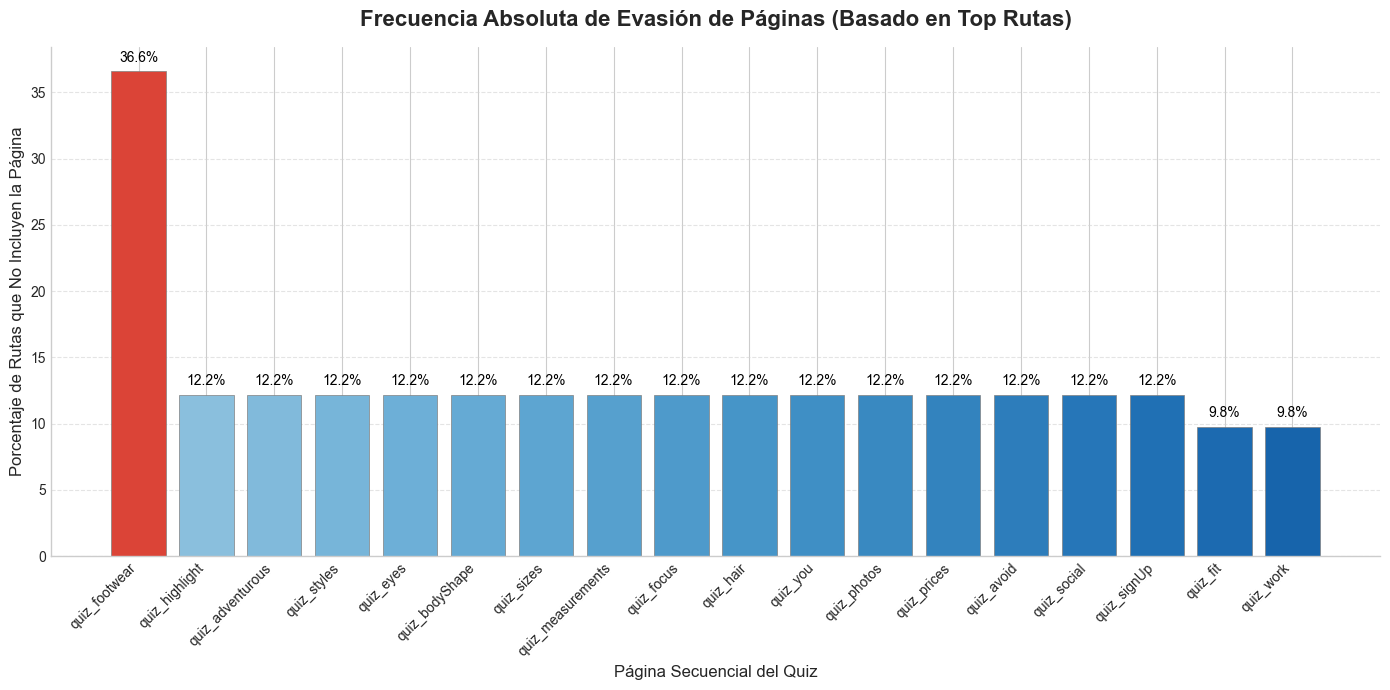

In [83]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 7), facecolor='white')

color_riesgo = '#DB4437' 
colores_base = plt.cm.Blues(np.linspace(0.4, 0.8, len(df_absence_viz_filtered)))
colores_finales = [color_riesgo if i == 0 else colores_base[i] 
                   for i in df_absence_viz_filtered.index] 

bars = plt.bar(df_absence_viz_filtered['Página Ausente'], 
               df_absence_viz_filtered['% de Rutas que Evasión'], 
               color=colores_finales, 
               edgecolor='gray', 
               linewidth=0.5)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, 
             f'{yval:.1f}%', ha='center', va='bottom', fontsize=10, color='black')

plt.title(f'Frecuencia Absoluta de Evasión de Páginas (Basado en Top Rutas)', 
          fontsize=16, pad=15, weight='bold')
plt.ylabel('Porcentaje de Rutas que No Incluyen la Página', fontsize=12)
plt.xlabel('Página Secuencial del Quiz', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

ax = plt.gca()
ax.grid(axis='y', linestyle='--', alpha=0.6, color='lightgray')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()

In [84]:
# print("El porcentaje se calcula como (Conteo de Ausencias / Total de Rutas Analizadas) * 100")
# print(df_absence_viz_filtered.to_markdown(index=False, floatfmt=".2f"))

### Análisis de Funnel de Conversión y Tiempo de Permanencia (Latencia)

In [85]:
df_flujo = df[df['section'].isin(flujo_ideal_lista)].copy()

reporte_funnel = []
anterior_conteo = 0

for i, pagina_actual in enumerate(flujo_ideal_lista):
    
    conteo_visitas = df_flujo[df_flujo['section'] == pagina_actual]['user_id'].nunique()
    
    latencia_media = df_flujo[df_flujo['section'] == pagina_actual]['latency_seconds'].mean()
    
    if i == 0:
        tasa_retencion = 100.0
        tasa_caida = 0.0
    else:
        tasa_retencion = (conteo_visitas / anterior_conteo) * 100 if anterior_conteo > 0 else 0.0
        tasa_caida = 100 - tasa_retencion
    
    anterior_conteo = conteo_visitas

    reporte_funnel.append({
        'Página': pagina_actual,
        'Usuarios_Pasaron': conteo_visitas,
        'Tasa_Retencion': tasa_retencion,
        'Tasa_Caida': tasa_caida,
        'Latencia_Promedio': latencia_media
    })

df_funnel = pd.DataFrame(reporte_funnel)
df_funnel['Latencia_H:M:S'] = df_funnel['Latencia_Promedio'].apply(seconds_to_hms)

C:\Users\marke\AppData\Local\Temp\ipykernel_1740\4118527105.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_funnel['Página'], rotation=45, ha='right')


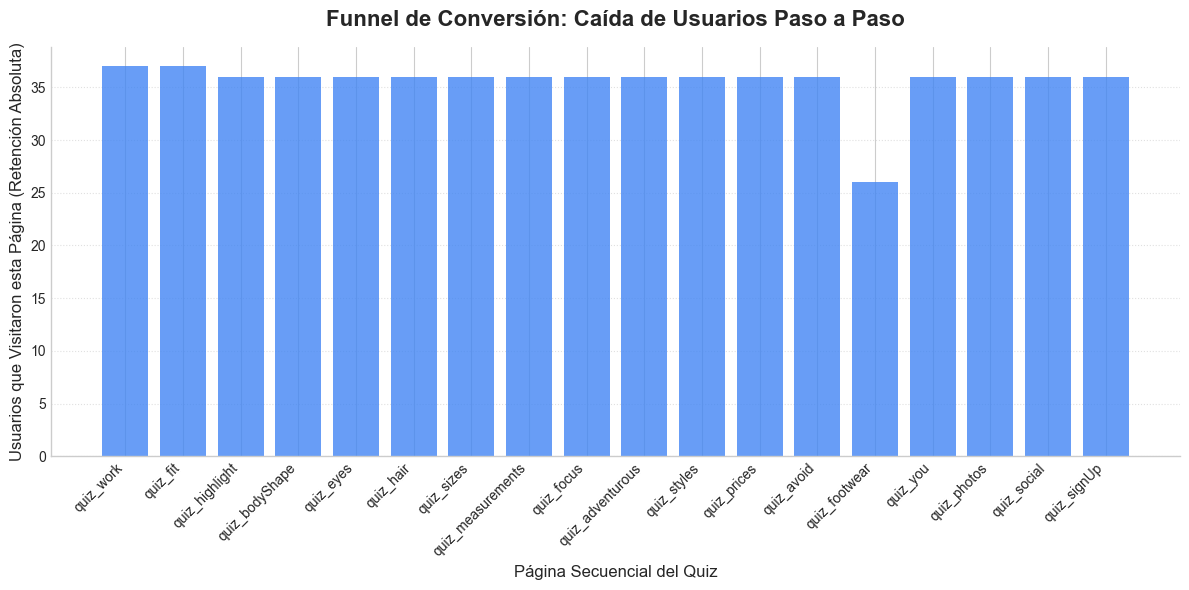

In [86]:

fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')
plt.style.use('seaborn-v0_8-whitegrid')

color_barra = '#4285F4'
barras = ax.bar(df_funnel['Página'], df_funnel['Usuarios_Pasaron'], color=color_barra, alpha=0.8)

ax.set_ylabel('Usuarios que Visitaron esta Página (Retención Absoluta)', fontsize=12)
ax.set_xlabel('Página Secuencial del Quiz', fontsize=12)
ax.set_title('Funnel de Conversión: Caída de Usuarios Paso a Paso', 
             fontsize=16, pad=15, weight='bold')



ax.set_xticklabels(df_funnel['Página'], rotation=45, ha='right')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y', linestyle=':', alpha=0.6)

plt.tight_layout()

C:\Users\marke\AppData\Local\Temp\ipykernel_1740\2508045290.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_funnel['Página'], rotation=45, ha='right')
C:\Users\marke\AppData\Local\Temp\ipykernel_1740\2508045290.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


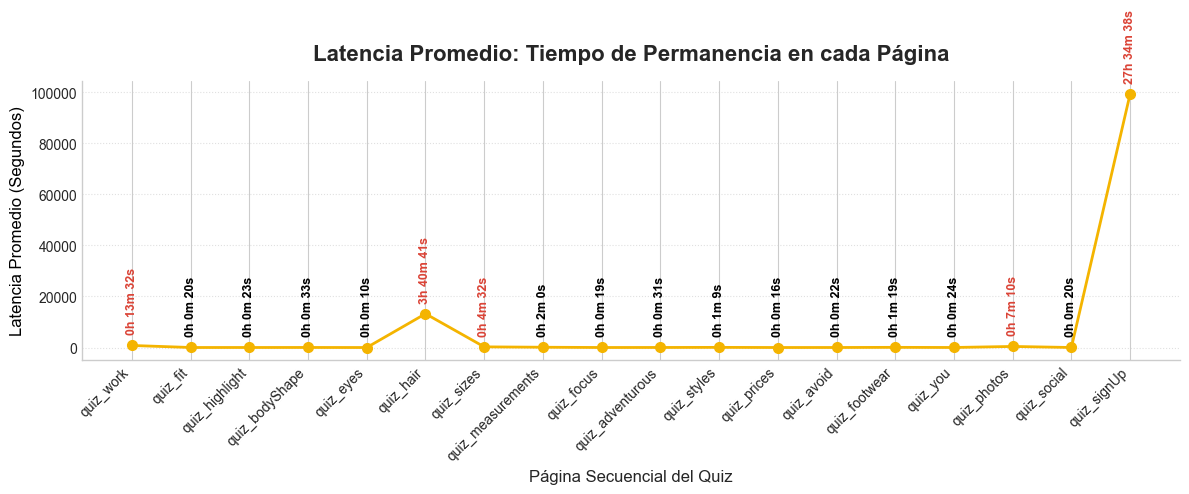

In [87]:
fig, ax = plt.subplots(figsize=(12, 5), facecolor='white')
plt.style.use('seaborn-v0_8-whitegrid')

color_linea = '#F4B400' 
linea = ax.plot(df_funnel['Página'], df_funnel['Latencia_Promedio'], 
        color=color_linea, marker='o', linewidth=2, linestyle='-', markersize=7)

ax.set_ylabel('Latencia Promedio (Segundos)', fontsize=12, color='black')
ax.set_xlabel('Página Secuencial del Quiz', fontsize=12)
ax.set_title('Latencia Promedio: Tiempo de Permanencia en cada Página', 
             fontsize=16, pad=15, weight='bold')

promedio_general_funnel = df_funnel['Latencia_Promedio'].mean()
for i, txt in enumerate(df_funnel['Latencia_H:M:S']):
    latencia_s = df_funnel.loc[i, 'Latencia_Promedio'] 
    
    color_txt = '#DB4437' if latencia_s > UMBRAL_ABANDONO_SEGUNDOS else 'black'
    
    ax.annotate(txt, (df_funnel['Página'][i], latencia_s), 
                textcoords="offset points", 
                xytext=(0, 10), 
                ha='center', 
                fontsize=9, 
                color=color_txt,
                weight='bold',
                rotation = "vertical")

ax.set_xticklabels(df_funnel['Página'], rotation=45, ha='right')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y', linestyle=':', alpha=0.6)
ax.legend()

plt.tight_layout()

In [88]:
df_funnel_final = df_funnel[['Página', 'Usuarios_Pasaron', 'Tasa_Caida', 'Latencia_H:M:S']].copy()
df_funnel_final.rename(columns={'Usuarios_Pasaron': 'Usuarios que Siguen', 'Tasa_Caida': 'Caída (%)'}, inplace=True)
df_funnel_final['Caída (%)'] = df_funnel_final['Caída (%)'].round(2)

print(df_funnel_final.to_markdown(index=False, floatfmt=".2f"))

| Página            |   Usuarios que Siguen |   Caída (%) | Latencia_H:M:S   |
|:------------------|----------------------:|------------:|:-----------------|
| quiz_work         |                    37 |        0.00 | 0h 13m 32s       |
| quiz_fit          |                    37 |        0.00 | 0h 0m 20s        |
| quiz_highlight    |                    36 |        2.70 | 0h 0m 23s        |
| quiz_bodyShape    |                    36 |        0.00 | 0h 0m 33s        |
| quiz_eyes         |                    36 |        0.00 | 0h 0m 10s        |
| quiz_hair         |                    36 |        0.00 | 3h 40m 41s       |
| quiz_sizes        |                    36 |        0.00 | 0h 4m 32s        |
| quiz_measurements |                    36 |        0.00 | 0h 2m 0s         |
| quiz_focus        |                    36 |        0.00 | 0h 0m 19s        |
| quiz_adventurous  |                    36 |        0.00 | 0h 0m 31s        |
| quiz_styles       |                    36 |       

## Análisis temporal

In [89]:
df.head()

,event_name,section,user_id,event_date,event_timestamp,next_timestamp,latency_seconds,next_section,seccion_anterior,tipo_transicion
0,page_view,quiz_work,040e1e30c9ed4248bc9799a707e36d60,2025-01-01,2025-01-01 16:57:15.062114990,2025-01-01 16:57:24.243407959,9.181293,quiz_fit,NaN,quiz_fit
1,page_view,quiz_fit,040e1e30c9ed4248bc9799a707e36d60,2025-01-01,2025-01-01 16:57:24.243407959,2025-01-01 16:57:37.877279053,13.633871,quiz_highlight,quiz_work,quiz_highlight
2,page_view,quiz_highlight,040e1e30c9ed4248bc9799a707e36d60,2025-01-01,2025-01-01 16:57:37.877279053,2025-01-01 16:57:52.290892090,14.413613,quiz_bodyShape,quiz_fit,quiz_bodyShape
3,page_view,quiz_bodyShape,040e1e30c9ed4248bc9799a707e36d60,2025-01-01,2025-01-01 16:57:52.290892090,2025-01-01 16:58:58.868198975,66.577307,quiz_eyes,quiz_highlight,quiz_eyes
4,page_view,quiz_eyes,040e1e30c9ed4248bc9799a707e36d60,2025-01-01,2025-01-01 16:58:58.868198975,2025-01-01 16:59:10.349990967,11.481792,quiz_hair,quiz_bodyShape,quiz_hair


In [90]:
df['hora_dia'] = df['event_timestamp'].dt.hour
df['dia_semana'] = df['event_timestamp'].dt.day_name()

orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['dia_nombre'] = df['event_timestamp'].dt.day_name()

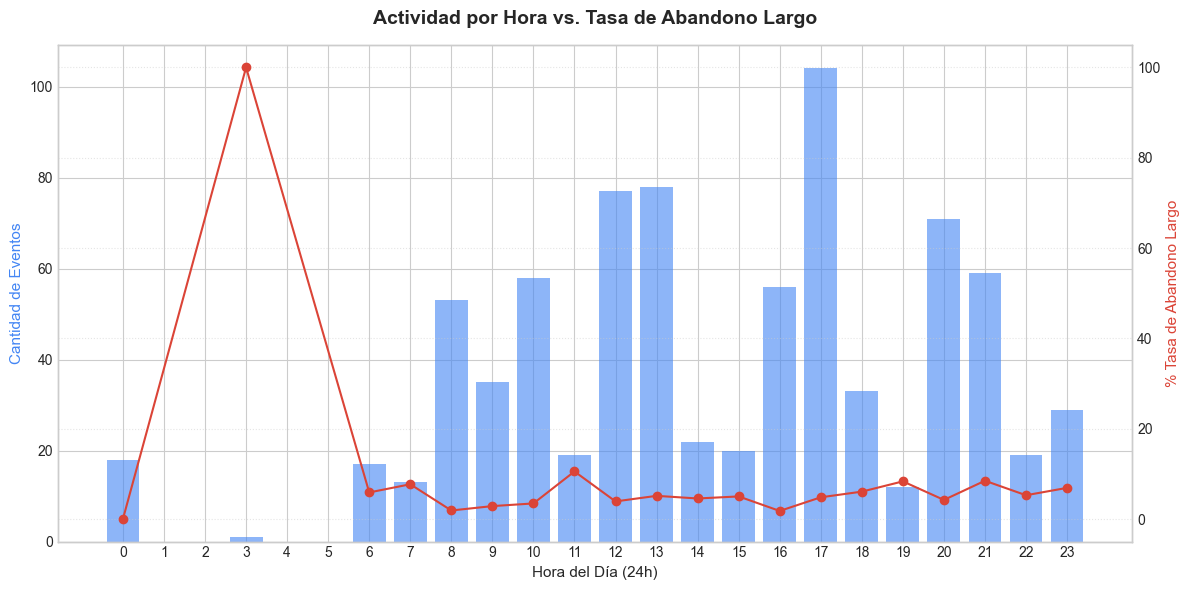

In [91]:
actividad_por_hora = df.groupby('hora_dia').agg(
    total_eventos=('user_id', 'count'),
    abandonos_largos=('tipo_transicion', lambda x: (x == 'ABANDONO_LARGO').sum())
).reset_index()

actividad_por_hora['tasa_abandono_hora'] = (actividad_por_hora['abandonos_largos'] / actividad_por_hora['total_eventos']) * 100

fig, ax1 = plt.subplots(figsize=(12, 6), facecolor='white')

ax1.bar(actividad_por_hora['hora_dia'], actividad_por_hora['total_eventos'], color='#4285F4', alpha=0.6, label='Volumen de Eventos')
ax1.set_xlabel('Hora del Día (24h)', fontsize=11)
ax1.set_ylabel('Cantidad de Eventos', color='#4285F4', fontsize=11)
ax1.set_xticks(range(0, 24))

ax2 = ax1.twinx()
ax2.plot(actividad_por_hora['hora_dia'], actividad_por_hora['tasa_abandono_hora'], color='#DB4437', marker='o', label='% Tasa Abandono')
ax2.set_ylabel('% Tasa de Abandono Largo', color='#DB4437', fontsize=11)

plt.title('Actividad por Hora vs. Tasa de Abandono Largo', fontsize=14, weight='bold', pad=15)
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.tight_layout()

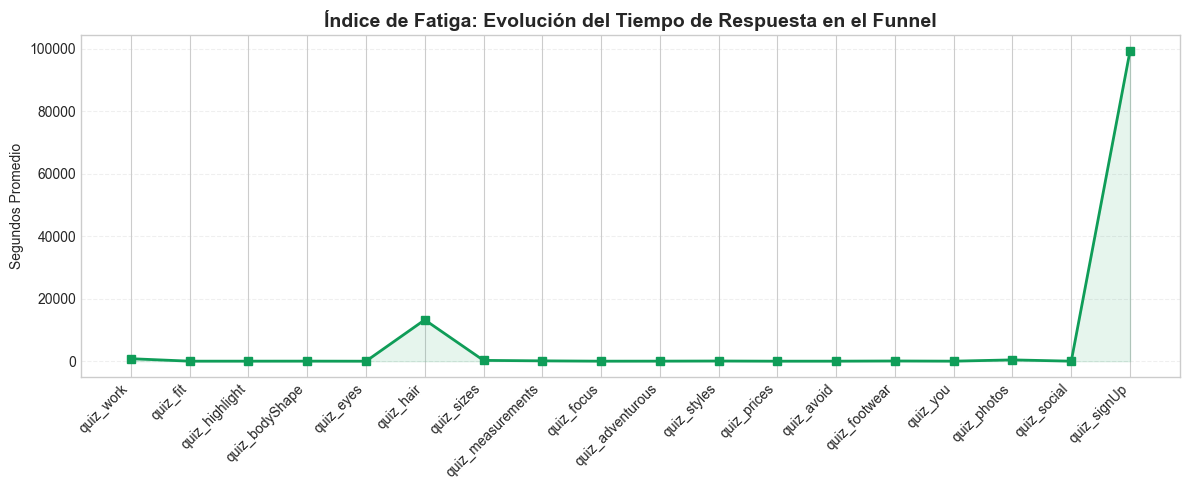

In [92]:
latencia_evolucion = df[df['section'].isin(flujo_ideal_lista)].groupby('section')['latency_seconds'].mean().reindex(flujo_ideal_lista)

plt.figure(figsize=(12, 5), facecolor='white')
plt.plot(latencia_evolucion.index, latencia_evolucion.values, marker='s', color='#0F9D58', linewidth=2)
plt.fill_between(latencia_evolucion.index, latencia_evolucion.values, color='#0F9D58', alpha=0.1)

plt.title('Índice de Fatiga: Evolución del Tiempo de Respuesta en el Funnel', fontsize=14, weight='bold')
plt.ylabel('Segundos Promedio')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()

In [93]:
hora_punta = actividad_por_hora.loc[actividad_por_hora['total_eventos'].idxmax(), 'hora_dia']

secciones_sin_final = latencia_evolucion.drop(index='quiz_signUp', errors='ignore')
seccion_fatiga = secciones_sin_final.idxmax()
tiempo_fatiga = seconds_to_hms(secciones_sin_final.max())
print(f"Hora de mayor actividad: {int(hora_punta)}:00h")
print(f"Punto de mayor fricción detectado: {seccion_fatiga} ({tiempo_fatiga})")

Hora de mayor actividad: 17:00h
Punto de mayor fricción detectado: quiz_hair (3h 40m 41s)


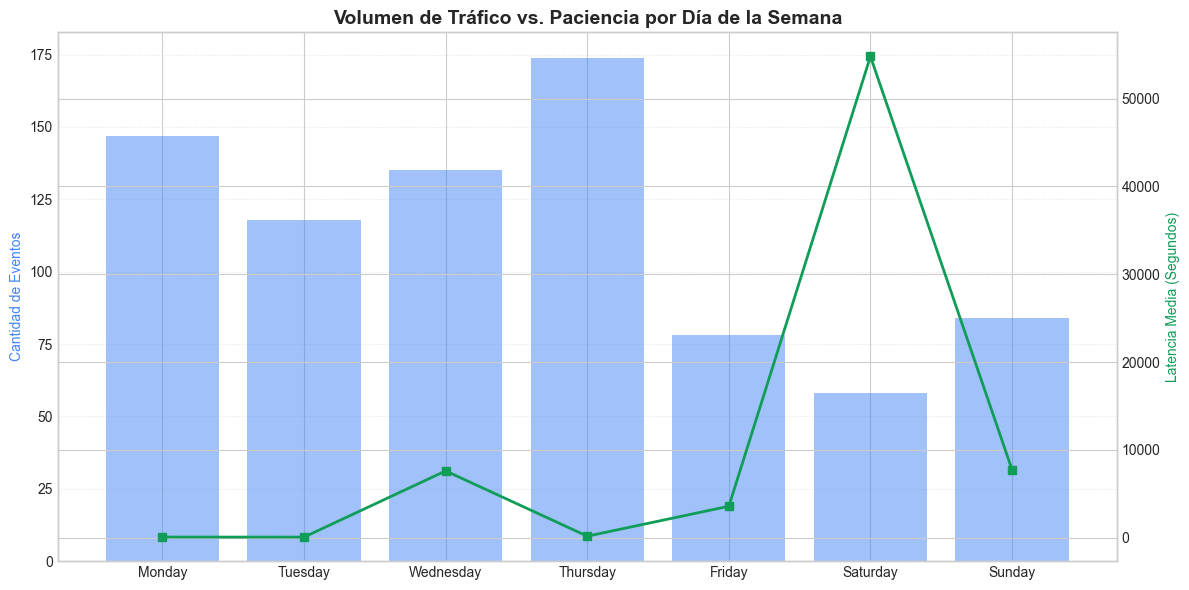

In [94]:
analisis_dias = df.groupby('dia_nombre').agg(
    eventos=('user_id', 'count'),
    latencia_media=('latency_seconds', 'mean')
).reindex(orden_dias)

fig, ax1 = plt.subplots(figsize=(12, 6), facecolor='white')

ax1.bar(analisis_dias.index, analisis_dias.eventos, color='#4285F4', alpha=0.5, label='Volumen de Tráfico')
ax1.set_ylabel('Cantidad de Eventos', color='#4285F4')

ax2 = ax1.twinx()
ax2.plot(analisis_dias.index, analisis_dias.latencia_media, color='#0F9D58', marker='s', linewidth=2, label='Latencia Media')
ax2.set_ylabel('Latencia Media (Segundos)', color='#0F9D58')

plt.title('Volumen de Tráfico vs. Paciencia por Día de la Semana', fontsize=14, weight='bold')
ax1.grid(axis='y', linestyle=':', alpha=0.5)
plt.tight_layout()

In [95]:
tiempos_usuario = df.groupby('user_id').agg(
    inicio=('event_timestamp', 'min'),
    fin=('event_timestamp', 'max'),
    pasos=('section', 'count')
)
tiempos_usuario['duracion_total'] = (tiempos_usuario['fin'] - tiempos_usuario['inicio']).dt.total_seconds()

usuarios_reales = tiempos_usuario[tiempos_usuario['pasos'] > 10]

duracion_mediana = usuarios_reales['duracion_total'].median()
duracion_media = usuarios_reales['duracion_total'].mean()

In [96]:
print(f"Duración Mediana del Test: {seconds_to_hms(duracion_mediana)}")
print(f"Duración Media del Test: {seconds_to_hms(duracion_media)}")
print(f"Basado en {len(usuarios_reales)} usuarios que completaron gran parte del flujo.")

Duración Mediana del Test: 0h 14m 44s
Duración Media del Test: 14h 39m 34s
Basado en 36 usuarios que completaron gran parte del flujo.


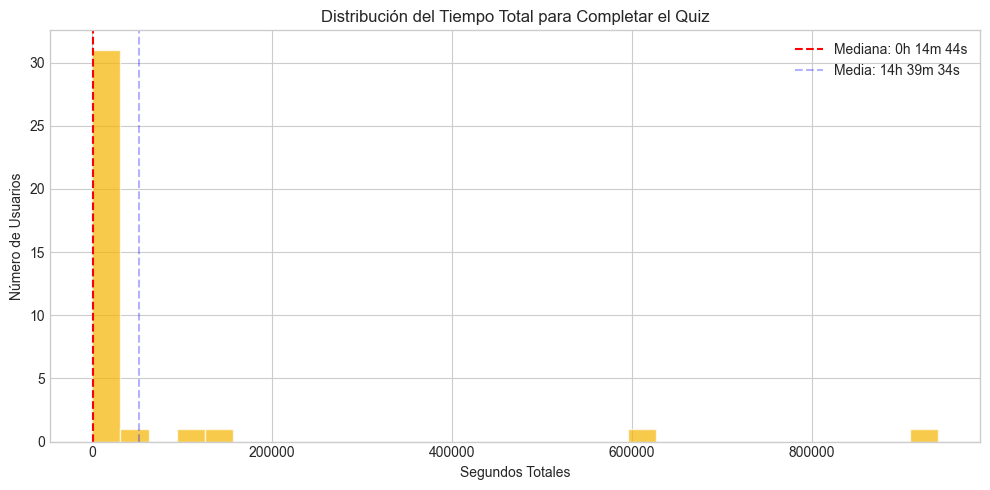

In [97]:
plt.figure(figsize=(10, 5))
plt.hist(usuarios_reales['duracion_total'], bins=30, color='#F4B400', edgecolor='white', alpha=0.7)
plt.axvline(duracion_mediana, color='red', linestyle='--', label=f'Mediana: {seconds_to_hms(duracion_mediana)}')
plt.axvline(duracion_media, color = "blue", alpha = 0.3, linestyle = "--", label=f'Media: {seconds_to_hms(duracion_media)}')
plt.title('Distribución del Tiempo Total para Completar el Quiz')
plt.xlabel('Segundos Totales')
plt.ylabel('Número de Usuarios')
plt.legend()
plt.tight_layout()

In [98]:
analisis_diario = df.groupby('event_date').agg(
    total_vistas=('user_id', 'count'),
    usuarios_unicos=('user_id', 'nunique'),
    abandonos=('tipo_transicion', lambda x: (x == 'ABANDONO_LARGO').sum())
).reset_index()

analisis_diario['tasa_abandono'] = (analisis_diario['abandonos'] / analisis_diario['total_vistas']) * 100

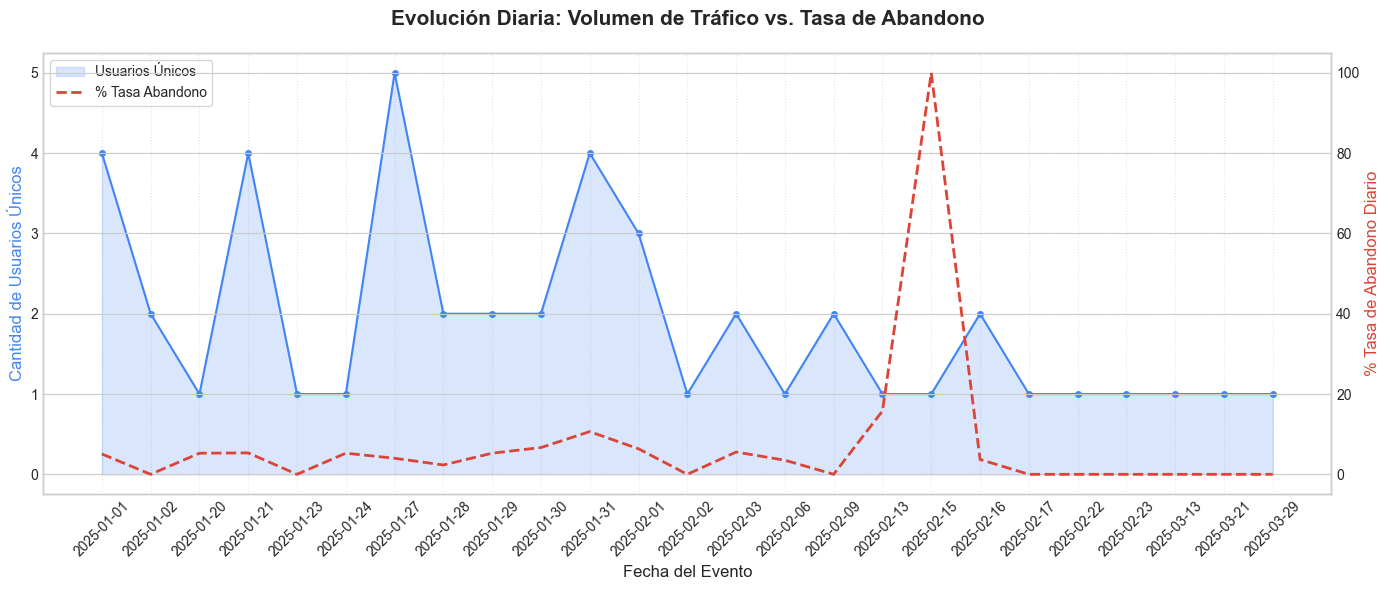

In [99]:
fig, ax1 = plt.subplots(figsize=(14, 6), facecolor='white')

ax1.fill_between(analisis_diario['event_date'], analisis_diario['usuarios_unicos'], 
                 color='#4285F4', alpha=0.2, label='Usuarios Únicos')
ax1.plot(analisis_diario['event_date'], analisis_diario['usuarios_unicos'], 
         color='#4285F4', marker='o', markersize=4, linewidth=1.5)

ax1.set_xlabel('Fecha del Evento', fontsize=12)
ax1.set_ylabel('Cantidad de Usuarios Únicos', color='#4285F4', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(analisis_diario['event_date'], analisis_diario['tasa_abandono'], 
         color='#DB4437', linestyle='--', linewidth=2, label='% Tasa Abandono')
ax2.set_ylabel('% Tasa de Abandono Diario', color='#DB4437', fontsize=12)

plt.title('Evolución Diaria: Volumen de Tráfico vs. Tasa de Abandono', fontsize=15, weight='bold', pad=20)
ax1.grid(axis='both', linestyle=':', alpha=0.5)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', frameon=True)

plt.tight_layout()

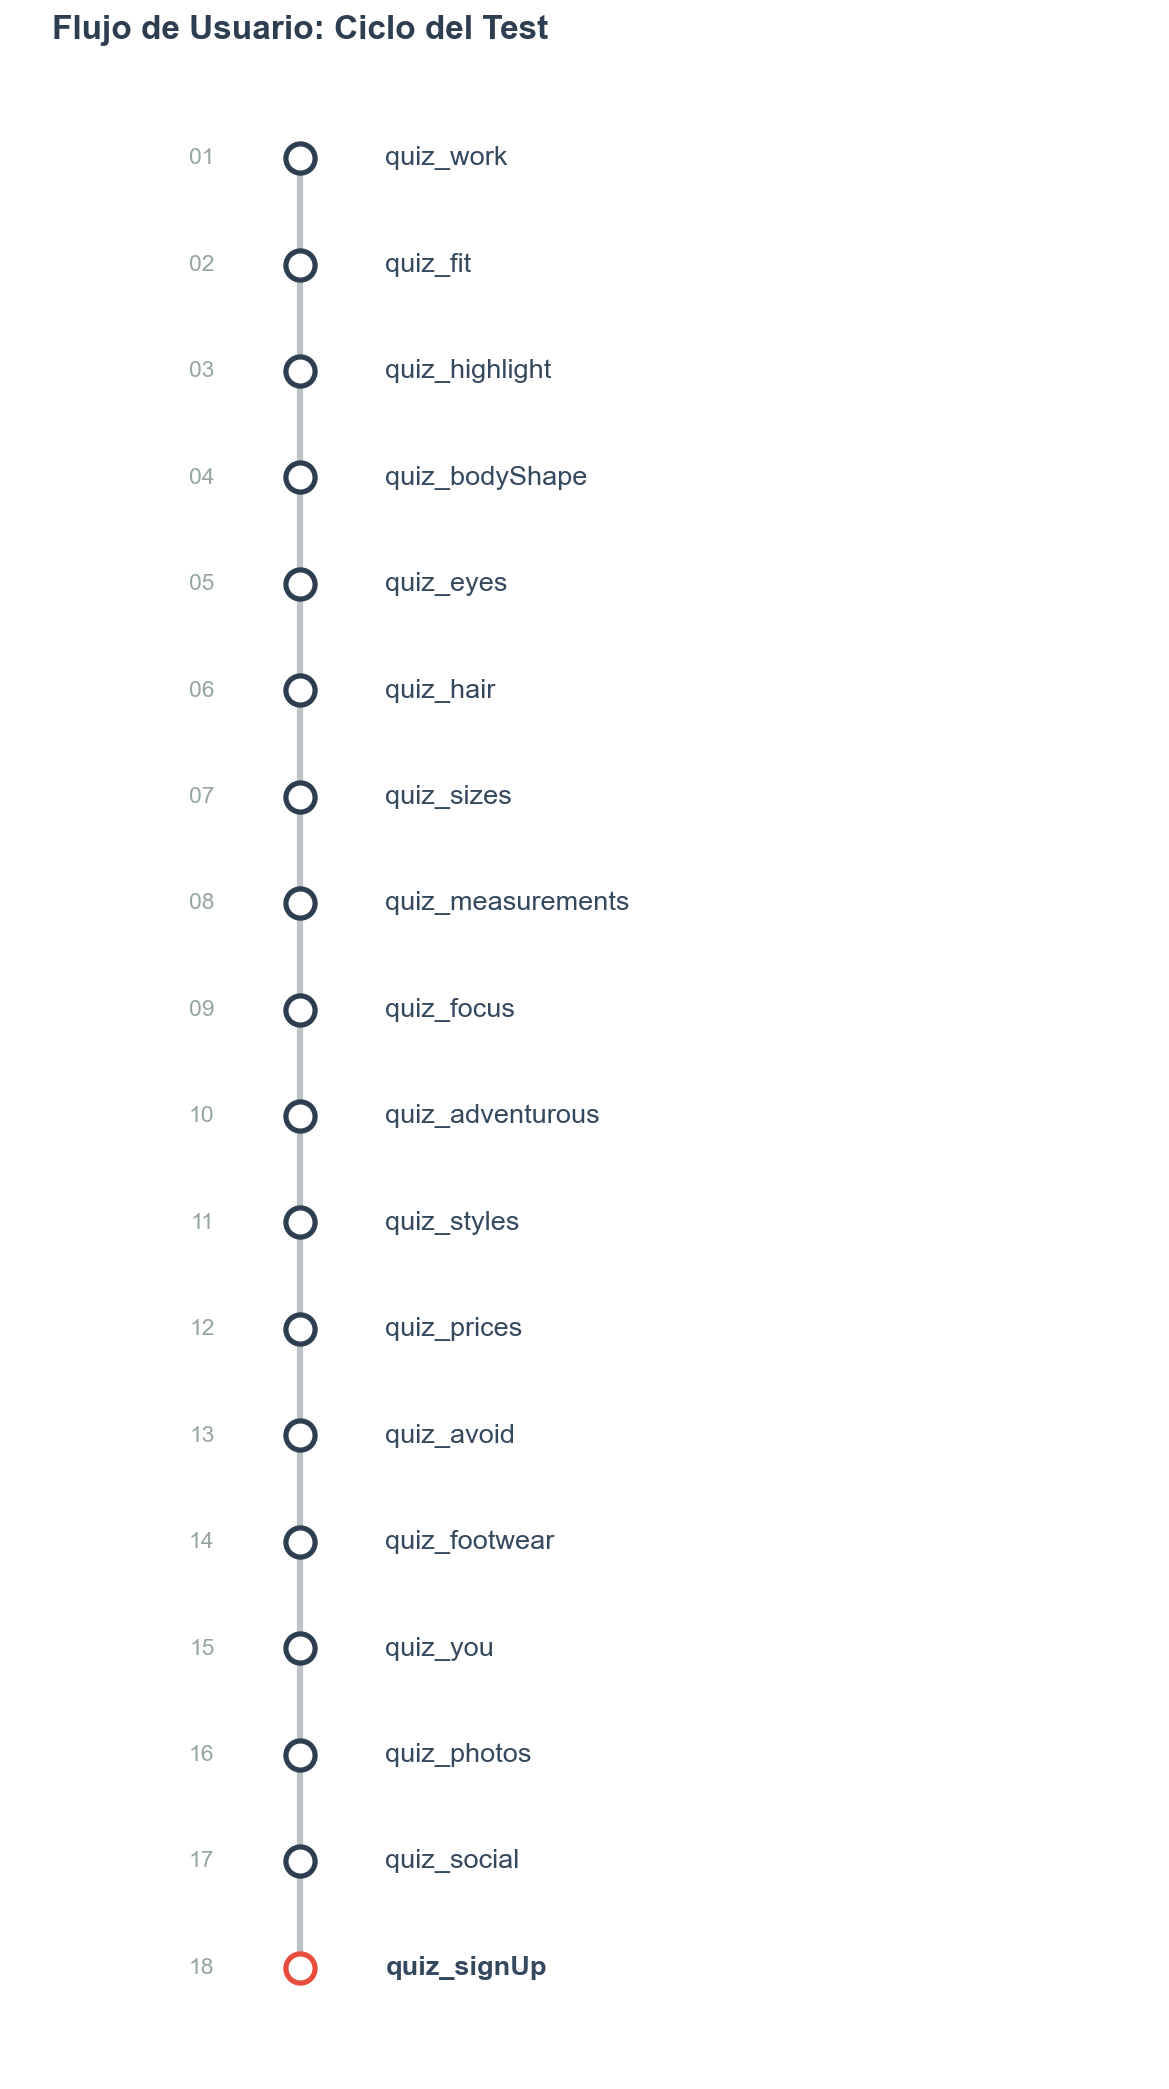

In [100]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

labels = FUNNEL_SEQUENCE
fig, ax = plt.subplots(figsize=(8, 14), dpi=150) 
ax.set_xlim(0, 4)
ax.set_ylim(0, len(labels) + 1)
ax.axis('off') # Sin ejes
fig.patch.set_facecolor('white')

# Colores 
color_line = '#bdc3c7'      
color_dot_fill = 'white'    
color_dot_edge = '#2c3e50'  
color_text = '#34495e'      
color_accent = '#e74c3c'    

ax.vlines(x=1, ymin=1, ymax=len(labels), color=color_line, linewidth=3, zorder=1)

for i, label in enumerate(labels):
    y_pos = len(labels) - i
    
    is_last = (i == len(labels) - 1)
    current_edge = color_accent if is_last else color_dot_edge
    current_text_weight = 'bold' if is_last else 'normal'
    
    ax.plot(1, y_pos, 'o', 
            markersize=14, 
            markerfacecolor=color_dot_fill, 
            markeredgecolor=current_edge, 
            markeredgewidth=2.5, 
            zorder=2)
    
    ax.text(0.7, y_pos, f"{i+1:02d}", 
            ha='right', va='center', 
            fontsize=11, color='#95a5a6', fontfamily='sans-serif')
    
    ax.text(1.3, y_pos, label, 
            ha='left', va='center', 
            fontsize=13, color=color_text, fontweight=current_text_weight, fontfamily='sans-serif')

ax.text(1, len(labels) + 1.2, "Flujo de Usuario: Ciclo del Test", 
        ha='center', va='center', fontsize=16, fontweight='bold', color='#2c3e50')

plt.tight_layout()
plt.show()